In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
from datetime import datetime

# Importando dataset MNIST

In [2]:
mnist = datasets.MNIST(root='.', download=False)
imgs = mnist.data
imgs = imgs.view((60000, 1, 28, 28)) # Reshaping the dataset do one channel each image

transformer = transforms.Compose([
    transforms.Normalize(mean=(0.5, ), std=(0.5,))
])

imgs = transformer(imgs/255.)
imgs.min(), imgs.max(), imgs.mean(), imgs.std()

/home/studio-lab-user/.conda/envs/principal/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1643072154070/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(tensor(-1.), tensor(1.), tensor(-0.7387), tensor(0.6162))

# Visualizando algumas imagens

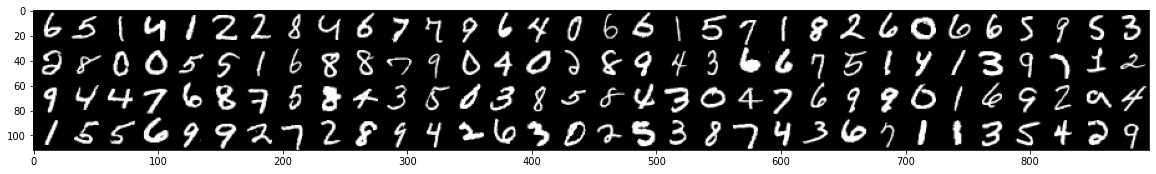

In [3]:
dataloader = DataLoader(imgs, batch_size=128, shuffle=True)
imgs_batch = next(iter(dataloader))
grid_tensor = make_grid(imgs_batch, nrow=32, padding=0, normalize=True)
grid_np = np.transpose(grid_tensor.detach().numpy(), (1, 2, 0))
plt.figure(figsize=(20, 5))
plt.imshow(grid_np)
plt.show()

# VARIÁVEIS

In [4]:
BATCH_SIZE = 128
NOISE_DIM = 10

# Criando o generator e discriminator

In [5]:
def create_generator(noise_dim_, output_channels_):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_channels=noise_dim_, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=128,out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=32, out_channels=output_channels_, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )
    return model

def create_discriminator():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

    return model

generator = create_generator(NOISE_DIM, 1)
noise = torch.randn((32, NOISE_DIM, 1, 1))
print (f'{noise.shape=}')
fake_img = generator(noise)
print (f'{fake_img.shape=}')

discriminator = create_discriminator()
output_discriminator = discriminator(fake_img)
print (f'{output_discriminator.shape=}')

noise.shape=torch.Size([32, 10, 1, 1])
fake_img.shape=torch.Size([32, 1, 28, 28])
output_discriminator.shape=torch.Size([32, 1, 1, 1])


# Funções úteis

In [7]:
def get_noise(b_size, noise_dim_, device_):
    #return torch.randn((b_size, noise_dim_, 1, 1), device=device_)
    return (torch.rand((b_size, noise_dim_, 1, 1), device=device_))*2 - 1

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(m.bias, val=0)

def tensor_of_ones(b_size_, device_):
    return 0.9*torch.ones((b_size, ), device=device_)

def tensor_of_zeros(b_size_, device_):
    return 0.1*torch.ones((b_size, ), device=device_)

def create_image(model, x, epoch):
    with torch.no_grad():
        fake_imgs = model(x)
        grid_tensor = make_grid(fake_imgs.detach().cpu(), nrow=16, padding=0, normalize=True)
        grid_np = np.transpose(grid_tensor.numpy(), (1, 2, 0))*255
        img_pil = Image.fromarray(grid_np.astype(np.uint8))
        img_pil.save(f'./imgs/img_{epoch}.jpg')

def criar_imagens_aleatorias(epoch):
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=(-1,), std=(1,)),
        transforms.ToPILImage()
    ])
    n_rows = 1
    n_columns = 8
    noise = torch.randn((n_rows*n_columns, NOISE_DIM, 1, 1), device=device)
    with torch.no_grad():
        fake_imgs = generator(noise)

    fake_imgs = fake_imgs.detach().cpu()
    
    plt.figure(figsize=(20, 5))
    for k in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, k+1)
        plt.imshow(inv_normalize(fake_imgs[k]))
        plt.xticks([])
        plt.yticks([])
    
    plt.savefig(f'./imgs/random_{epoch}.jpg', pad_inches=0)

def save_checkpoint(g_model: nn.Module, d_model: nn.Module, epoch, results):
    checkpoint = {
        'generator_state_dict': g_model.state_dict(),
        'discriminator_state_dict': d_model.state_dict(),
        'epochs': epoch,
        'results': results,
        'time_creation': datetime.now().strftime('%d/%m/%Y, %H:%M')
    }
    torch.save(checkpoint, f'./models/checkpoint_{epoch}.pt')

noise = get_noise(8, 100, torch.device('cpu'))
print (f'{noise.shape=}')

noise.shape=torch.Size([8, 100, 1, 1])


# Treinamento

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

print ('Criando os modelos...')
discriminator = create_discriminator()
generator = create_generator(noise_dim_=NOISE_DIM, output_channels_=1)

print ('Iniciando os pesos de acordo com a distribuição normal')
discriminator.apply(weights_init)
generator.apply(weights_init)

print ('Jogando para o device')
discriminator.to(device)
generator.to(device)

print ('Criando o criterion BCEWithLogitsLoss')
criterion = nn.BCEWithLogitsLoss()
criterion.to(device)

print ('Criando os otimizadores')
optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_generator = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

print ('Instanciando o dataloader')
dataloader = DataLoader(imgs, batch_size=BATCH_SIZE, shuffle=True)
len_dataloader = len(dataloader)
print (f'{len_dataloader=}')

fixed_noise = get_noise(8, NOISE_DIM, device)

device=device(type='cuda', index=0)
Criando os modelos...
Iniciando os pesos de acordo com a distribuição normal
Jogando para o device
Criando o criterion BCEWithLogitsLoss
Criando os otimizadores
Instanciando o dataloader
len_dataloader=469


In [ ]:
cabecalho = ['epoch', 'd_fake_loss', 'd_real_loss', 'g_loss']
print ('|'.join([str(c).center(20) for c in cabecalho]))

discriminator.train()
generator.train()
results = []

with torch.set_grad_enabled(True):
    for epoch in range(1, 20_000+1, 1):
        mean_fake_loss, mean_real_loss, mean_g_loss = [], [], []
        for real_imgs in dataloader:
            b_size = len(real_imgs)
            real_imgs = real_imgs.to(device)

            # Treinando o discriminator
            optim_discriminator.zero_grad()
            output_real = discriminator(real_imgs)
            real_loss = criterion(output_real.view(-1), tensor_of_ones(b_size, device))

            noise = get_noise(b_size, NOISE_DIM, device)
            fake_imgs = generator(noise)
            output_fake = discriminator(fake_imgs.detach())
            fake_loss = criterion(output_fake.view(-1), tensor_of_zeros(b_size, device))

            discriminator_loss = (fake_loss + real_loss)
            discriminator_loss.backward()

            optim_discriminator.step()
            
            mean_fake_loss.append(fake_loss.item())
            mean_real_loss.append(real_loss.item())

            # Treinando o generator
            optim_generator.zero_grad()
            output_for_generator = discriminator(fake_imgs)
            generator_loss = criterion(output_for_generator.view(-1), tensor_of_ones(b_size, device))
            generator_loss.backward()
            optim_generator.step()

            mean_g_loss.append(generator_loss.item())
        
        mean_fake_loss = np.array(mean_fake_loss).mean()
        mean_real_loss = np.array(mean_real_loss).mean()
        mean_g_loss = np.array(mean_g_loss).mean()
        
        vetor = [epoch, mean_fake_loss, mean_real_loss, mean_g_loss]
        results.append(vetor)
        
        if (epoch % 100 == 0): print ('|'.join([str(round(v, 3)).center(20) for v in vetor]))

        if (epoch % 200 == 0): 
            create_image(generator, fixed_noise, epoch)
            criar_imagens_aleatorias(epoch)
            save_checkpoint(generator, discriminator, epoch, results)

# Analisando algumas imagens novas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


fake_imgs.shape=torch.Size([128, 1, 28, 28]), fake_imgs.min()=tensor(0.), fake_imgs.max()=tensor(1.9999), fake_imgs.mean()=tensor(0.1291), fake_imgs.std()=tensor(0.4283)


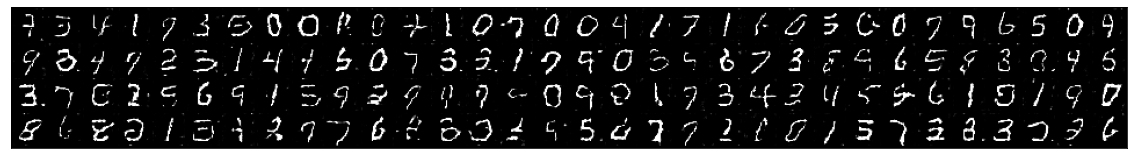

In [16]:
inv_normalize = transforms.Normalize(mean=(-1,), std=(1,))

noise = get_noise(128, NOISE_DIM, device)
with torch.no_grad():
    fake_imgs = generator(noise)

fake_imgs = fake_imgs.detach().cpu()
fake_imgs = inv_normalize(fake_imgs)

print (f'{fake_imgs.shape=}, {fake_imgs.min()=}, {fake_imgs.max()=}, {fake_imgs.mean()=}, {fake_imgs.std()=}')
grid_tensor = make_grid(fake_imgs, nrow=32, paddding=0, normalize=False)
grid_np = np.transpose(grid_tensor.numpy(), (1, 2, 0))

plt.figure(figsize=(20, 6))
plt.imshow(grid_np)
plt.xticks([])
plt.yticks([])
plt.show()